# Data Exploration for Ocean Central

Notebook for Ocean Central data prep and exploration. For now, the plan is to have all of the data work happen in this notebook, but if it gets too big, we can break it out by dataset. We want to keep things easy to update and in one place to stay flexible and agile for the design team.

## Datasets
1. [Marine Protected Areas](###Marine-Protected-Areas)


In [1]:
import os
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm

### Marine Protected Areas

Shapes and metadata representing marine protected areas. Data was sourced from the [World Database of Protected Areas](https://www.protectedplanet.net/en/thematic-areas/wdpa?tab=WDPA).

For detailed information, see this [document](https://wdpa.s3-eu-west-1.amazonaws.com/WDPA_Manual/English/WDPA_WDOECM_Manual_1_6.pdf). Specifically, page 16 has the spec for each field in the datasets.

The data comes as three shapefiles with names like `WDPA_MOYEAR_Public_shp_{0, 1, 2}.zip`, and our first step is to combine them. To use this dataset, first, add the unzipped directories to `./data` and run the consolidation cell below.

In [8]:
# Consolidate the MPA shapefiles into a single GeoDataFrame, mpa_gdf.geojson if it doesn't already exist
# This took ~12 minutes on my M1 Macbook Pro

if os.path.exists("./data/mpa_gdf.geojson"):
    mpa_gdf = gpd.read_file("./data/mpa_gdf.geojson")
else:
    gdfs = []
    for filename in tqdm(glob("./data/*/*.shp")):
        gdf = gpd.read_file(filename)
        gdfs.append(gdf)

    mpa_gdf = pd.concat(gdfs)
    mpa_gdf = mpa_gdf.to_crs(epsg=4326)
    mpa_gdf = mpa_gdf[mpa_gdf["MARINE"] != "0"]  # Only keep marine protected areas
    mpa_gdf.to_file("./data/mpa_gdf.geojson", driver="GeoJSON")
    del gdfs

100%|██████████| 6/6 [09:54<00:00, 99.06s/it] 


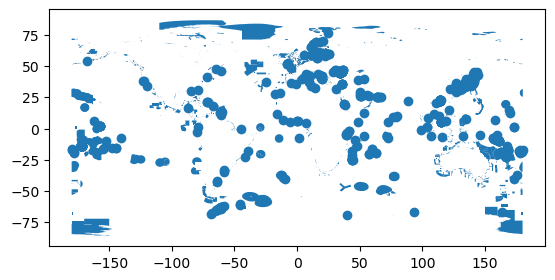

In [9]:
# Map the MPAs
mpa_gdf.plot()
plt.show()

In [11]:
# Plot the total area of MPAs over time
mpa_gdf["year"] = pd.to_datetime(mpa_gdf["STATUS_YR"], format="%Y", errors="coerce").dt.year
mpa_gdf["marine_area"].groupby(mpa_gdf["REP_M__AREA"]).sum().plot()
plt.ylabel("Area (km$^2$)")
plt.xlabel("Year")
plt.show()

KeyError: 'marine_area'

In [13]:
mpa_gdf.columns

Index(['WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NAME', 'DESIG',
       'DESIG_ENG', 'DESIG_TYPE', 'IUCN_CAT', 'INT_CRIT', 'MARINE',
       'REP_M_AREA', 'GIS_M_AREA', 'REP_AREA', 'GIS_AREA', 'NO_TAKE',
       'NO_TK_AREA', 'STATUS', 'STATUS_YR', 'GOV_TYPE', 'OWN_TYPE',
       'MANG_AUTH', 'MANG_PLAN', 'VERIF', 'METADATAID', 'SUB_LOC',
       'PARENT_ISO', 'ISO3', 'SUPP_INFO', 'CONS_OBJ', 'geometry', 'year'],
      dtype='object')

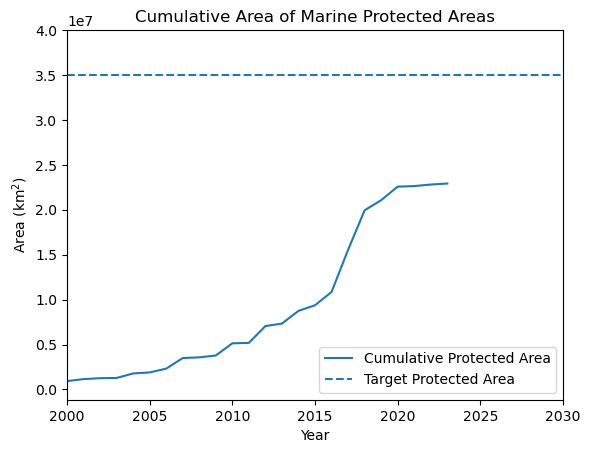

In [34]:
# Plot the cumulative area of MPAs over time
mpa_gdf["REP_M_AREA"].groupby(mpa_gdf["year"]).sum().cumsum().plot()
plt.ylabel("Area (km$^2$)")
plt.xlabel("Year")
plt.xlim(left=2000)
plt.ylim(top=40000000)
plt.hlines(35000000, 2000, 2030, linestyles="dashed", label="Target Protected Area")
plt.legend(["Cumulative Protected Area", "Target Protected Area"], loc="lower right")
plt.title("Cumulative Area of Marine Protected Areas")
plt.show()

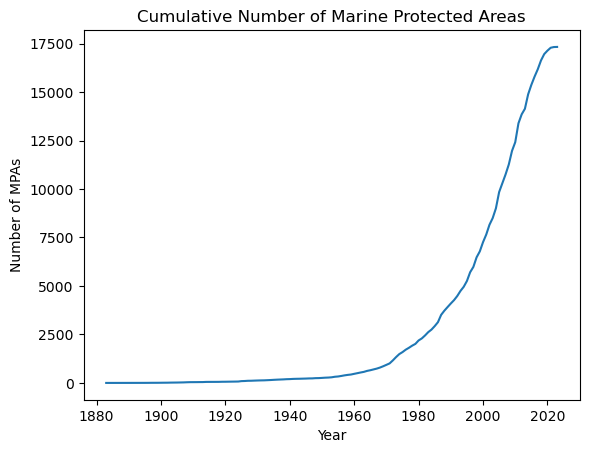

In [33]:
# Plot the cumulative number of MPAs over time
mpa_gdf["REP_M_AREA"].groupby(mpa_gdf["year"]).count().cumsum().plot()
plt.ylabel("Number of MPAs")
plt.xlabel("Year")
# plt.xlim(left=2000)
# plt.ylim(top=3000)
# plt.hlines(3000, 2000, 2030, linestyles="dashed", label="Target Number of MPAs")
plt.title("Cumulative Number of Marine Protected Areas")
plt.show()